In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams['text.usetex'] = True

# Set fonts for Matplotlib
plt.rcParams['font.serif'] = 'Palatino'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['font.monospace'] = 'Courier'
plt.rcParams['font.size'] = 11
width_cm = 15
height_cm = 6
# Convert centimeters to inches
width_in = width_cm / 2.54
height_in = height_cm / 2.54
import seaborn as sns
sns.set_theme()
figsize= (width_in, height_in)



import os
from metrics.plotting_utils import save_plot, get_history_from_project, save_csv, get_dataset_name_mapping
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import wandb
api = wandb.Api()
from ood_detection.config import Config
from datasets.config import DATASETS_DICT
dataset_mapping = get_dataset_name_mapping()


/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = get_history_from_project('thesis-logreg_linear_ablation-10-runs')

In [3]:
working_df = df.copy()

In [4]:
working_df = working_df.sort_index()

<AxesSubplot:xlabel='name'>

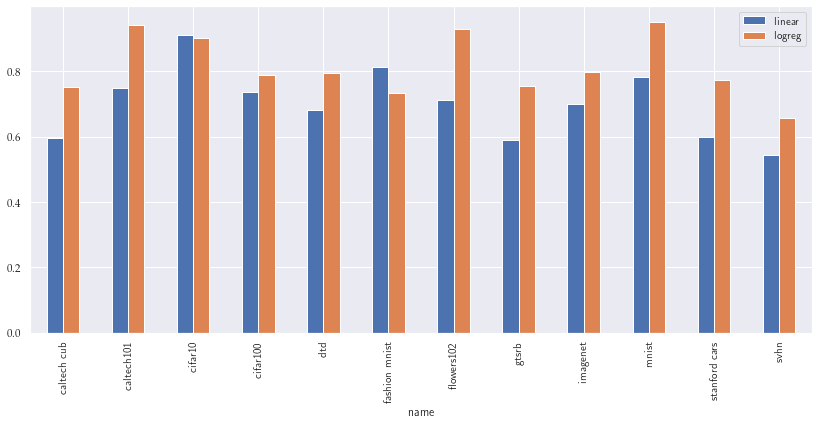

In [5]:
working_df.drop([col for col in working_df.columns if "_std" in col], axis=1).plot(figsize=(14,6), kind='bar')

In [6]:
def plot_errorbar(df, value_column, name):
    error_corr = .5 * df[value_column + '_std']
    lower = df[value_column] - error_corr
    upper = df[value_column] + error_corr
    #mean = df[value_column].mean().round(3)
    #std = u"\u00B1{})".format(df[value_column+'-std'].mean().round(2))
    #label = name + f' (\u03bc= {mean}' + std
    
    ax.plot(df[value_column], label = name)
    ax.plot(lower, color='tab:blue', alpha=.1)
    ax.plot(upper, color='tab:blue', alpha=.1)
    ax.fill_between(range(len(df)), lower, upper, alpha=.3)

/tmp/ipykernel_908/3258070467.py:5: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.vlines([range(len(working_df))], ymin=0, ymax=working_df.max(axis=1),color='darkgrey', alpha=0.6)
/tmp/ipykernel_908/3258070467.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([dataset_mapping[ind] for ind in working_df.index], rotation=45, ha='right')


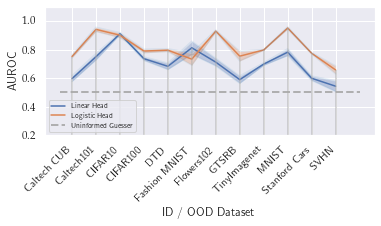

Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/appendix
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/appendix
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/appendix


True

<Figure size 432x288 with 0 Axes>

In [7]:
fig, ax = plt.subplots(figsize=figsize)
plot_errorbar(working_df, 'linear', 'Linear Head')
plot_errorbar(working_df, 'logreg', 'Logistic Head')
ax.hlines(0.5, xmin=-.5, xmax=[len(working_df)], colors='darkgrey', alpha=0.9, linestyles='--', lw=2, label='Uninformed Guesser')
ax.vlines([range(len(working_df))], ymin=0, ymax=working_df.max(axis=1),color='darkgrey', alpha=0.6)

ax.set_ylim(0.2,1.1)
ax.set_xticklabels([dataset_mapping[ind] for ind in working_df.index], rotation=45, ha='right')
ax.legend(fontsize=7)
ax.set_xlabel('ID / OOD Dataset')
ax.set_ylabel('AUROC')
# ax.set_title('Near-OOD Detection with Zero-Shot Methods')
#plt.tight_layout()
plt.show()
save_plot(fig, 'logreg_vs_linear', 'appendix', False)

In [8]:
new = {}
new['name'] = []
new['Linear Acc'] = []
for name in DATASETS_DICT.keys():
    curr_df = get_history_from_project(f'thesis-classification-linear_head-{name}')
    acc = curr_df.loc['test'].dropna()[0]
    new['name'].append(name)
    new['Linear Acc'].append(acc)

In [9]:
linear_df = pd.DataFrame.from_dict(new).set_index('name')

In [10]:
logistic_df = get_history_from_project('thesis-logreg-classification').rename(columns={'Acc':'Logistic Acc'})

In [11]:
classification_df = pd.concat([linear_df, logistic_df.drop('C', axis=1)], axis=1)
classification_df = classification_df * 100

In [12]:
classification_df = classification_df.reset_index()

In [13]:
classification_df.name = classification_df.name.apply(lambda x: dataset_mapping[x])

In [14]:
save_csv(classification_df.set_index('name').round(2),'appendix', 'full_classification')

In [15]:
classification_df.round(2).mean().round(2)

/tmp/ipykernel_908/729918131.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  classification_df.round(2).mean().round(2)


Linear Acc      82.72
Logistic Acc    83.36
dtype: float64

## Decoder Training

In [16]:
csv_path = os.path.join(Config.DATAPATH, 'csvs')

In [17]:
csv = os.path.join(csv_path, 'decoder_mean_losses.csv')
train_loss = pd.read_csv(csv)
train_loss.rename(columns={'COCO 25 Epochs 0.0001 - train mean loss': 'Train Loss', 'COCO 25 Epochs 0.0001 - val mean loss': 'Validation Loss'}, inplace=True)

Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/appendix
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/appendix
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/appendix


True

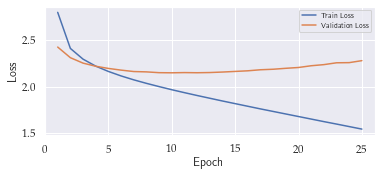

In [18]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(train_loss['epoch'], train_loss['Train Loss'], label='Train Loss')
ax.plot(train_loss['epoch'], train_loss['Validation Loss'], label='Validation Loss')
ax.legend(fontsize=7)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_xlim(0, 26)
# ax.set_xticks(train_loss['epoch'])
save_plot(fig, 'decoder', 'appendix', False)

## Temperature & Templates

In [19]:
df_custom = get_history_from_project('thesis-near_ood-temperature-ct-temps', False)
df_default = get_history_from_project('thesis-near_ood-temperature-dt-temps', False)

In [20]:
custom = df_custom.copy()
default = df_default.copy()

In [21]:
temp_custom = custom.groupby('temperature').mean().sort_values('temperature', ascending=True)[['mlp', 'msp']]
temp_default = default.groupby('temperature').mean().sort_values('temperature', ascending=True)[['mlp', 'msp']]

/tmp/ipykernel_908/1323948193.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp_custom = custom.groupby('temperature').mean().sort_values('temperature', ascending=True)[['mlp', 'msp']]
/tmp/ipykernel_908/1323948193.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp_default = default.groupby('temperature').mean().sort_values('temperature', ascending=True)[['mlp', 'msp']]


In [22]:
temp_custom.mean()

mlp    0.713718
msp    0.719013
dtype: float64

In [23]:
temp_default.mean()

mlp    0.721214
msp    0.715265
dtype: float64

Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/appendix
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/appendix
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/appendix


True

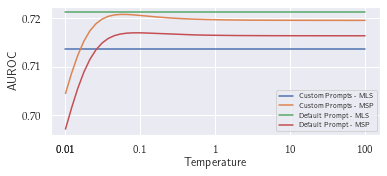

In [24]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(temp_custom.index, temp_custom['mlp'], label = 'Custom Prompts - MLS')
ax.plot(temp_custom.index, temp_custom['msp'],  label = 'Custom Prompts - MSP')

ax.plot(temp_default.index, temp_default['mlp'], label = 'Default Prompt - MLS')
ax.plot(temp_default.index, temp_default['msp'],  label = 'Default Prompt - MSP')

ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(fontsize=7)
ax.set_xlabel('Temperature')
ax.set_ylabel('AUROC')
# ax.hlines(0.5, xmin=-.5, xmax=[len(temp_default)], colors='darkgrey', alpha=0.9, linestyles='--', lw=2, label='Uninformed Guesser')
custom_ticks = [0.01, 0.01, 0.1, 1, 10, 100]
ax.set_xticks(custom_ticks)
ax.set_xticklabels(custom_ticks)

save_plot(fig, 'temperature-prompts-near' ,'appendix', False)

### ZOC

In [25]:
zoc_temps = get_history_from_project('thesis-ablation-zoc_temps', False)

In [26]:
zoc_temps.head(1)

,zoc,zoc_std,temperature,name
0,0.728144,0.015571,0.001,stanford cars


In [27]:
groups = zoc_temps.groupby('name')

In [28]:
def plot_zoc_errorbar(df, value_column, name):
    error_corr = .5 * df[value_column + '_std']
    lower = df[value_column] - error_corr
    upper = df[value_column] + error_corr
    #mean = df[value_column].mean().round(3)
    #std = u"\u00B1{})".format(df[value_column+'-std'].mean().round(2))
    #label = name + f' (\u03bc= {mean}' + std
    
    ax.plot(df['temperature'], df[value_column], label = name)
    ax.plot(df['temperature'], lower, color='tab:blue', alpha=.1)
    ax.plot(df['temperature'], upper, color='tab:blue', alpha=.1)
    ax.fill_between(df['temperature'], lower, upper, alpha=.3)

/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/tikzplotlib/_cleanfigure.py:166: UserWarning: Cleaning Line Collections (scatter plot) is not supported yet.
  warnings.warn(


Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/appendix
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/appendix
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/appendix


True

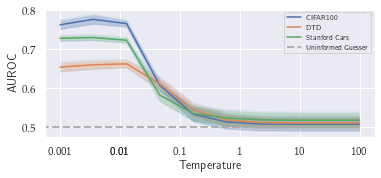

In [29]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=figsize)
ax.set_yscale('linear')
ax.set_xscale('log')

for name, group in groups:
    plot_zoc_errorbar(group, 'zoc', dataset_mapping[name])
ax.hlines(0.5, xmin=-.5, xmax=[len(group)], colors='darkgrey', alpha=0.9, linestyles='--', lw=2, label='Uninformed Guesser')

ax.legend(fontsize=7)
ax.set_xlabel('Temperature')
ax.set_ylabel('AUROC')
custom_ticks = [0.001, 0.01, 0.01, 0.1, 1, 10, 100]
ax.set_xticks(custom_ticks)
ax.set_xticklabels(custom_ticks)
save_plot(fig, 'zoc-temps' ,'appendix', False)

### kshot ablation


In [30]:
kshot = pd.read_csv(os.path.join(csv_path, 'linear_kshots.csv'))

In [31]:
sets = ['imagenet', 'gtsrb', 'svhn', 'mnist', 'cifar100', 'cifar10', 'fashion mnist']

In [32]:
cols = ['linear', 'tipf', 'clip']

In [33]:
sets_cols = []
for s in sets:
    for c in cols:
        sets_cols.append(" - ".join([s, c]))
sets_cols.append('shots')

In [34]:
kshots = kshot[sets_cols]

/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/tikzplotlib/_cleanfigure.py:166: UserWarning: Cleaning Line Collections (scatter plot) is not supported yet.
  warnings.warn(


Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/appendix
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/appendix
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/appendix


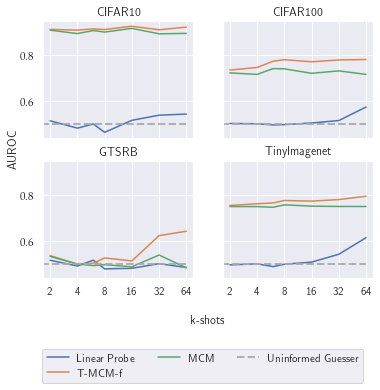

In [35]:
fig, axs = plt.subplots(2,2, figsize=(15/2.54, 12/2.54), sharey=True, sharex=True)
lines = [] # to hold the lines of each subplot
labels = [] # to hold the unique labels
for i, name in enumerate(['cifar10', 'cifar100', 'gtsrb','imagenet' ]):
    for label, strat in [('Linear Probe', 'linear'), ('T-MCM-f','tipf'), ('MCM', 'clip')]:
    
        line, = axs[i//2, i%2].plot(kshots['shots'], kshots[" - ".join([name, strat])], label=label)
        axs[i//2, i%2].set_title(dataset_mapping[name])
        if label not in labels:
            labels.append(label)
            lines.append(line)

# add the horizontal line outside the loop, with the 'Uninformed Guesser' label
for ax in axs.flat:
    line = ax.hlines(0.5, xmin=0, xmax=kshots['shots'].max(), colors='darkgrey', alpha=0.9, linestyles='--', lw=2, label='Uninformed Guesser')
# add the 'Uninformed Guesser' line to the list of lines for the legend
lines.append(line)

# set the x-axis to have a log2 scale
for ax in axs.flat:
    ax.set_xscale('log', base=2)
    
for ax in axs.flat:
    ax.set_xticks([2, 4, 8, 16, 32, 64])
    ax.set_xticklabels([2, 4, 8, 16, 32, 64])  # Set custom tick labels

    
fig.text(0.04, 0.5, 'AUROC', va='center', rotation='vertical')
fig.text(0.47, 0., 'k-shots', va='center', rotation='horizontal')


# create a shared legend outside of the subplots and position it relative to the figure
fig.legend(lines, [line.get_label() for line in lines], loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.2))
save_plot(fig, name='kshot_ablation', chapter='appendix', test_version=False)
plt.show()


<AxesSubplot:>

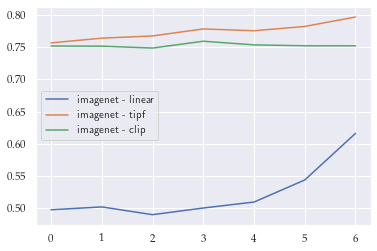

In [36]:
kshots[[n for n in kshots.columns if "imagenet" in n]].plot()

<AxesSubplot:>

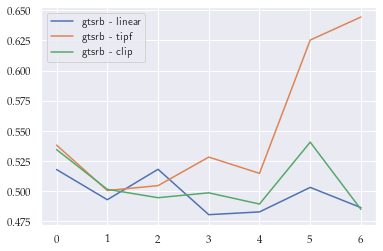

In [37]:
kshots[[n for n in kshots.columns if "gtsrb" in n]].plot()

<AxesSubplot:>

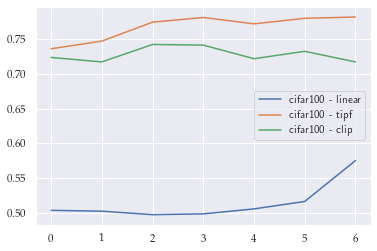

In [38]:
kshots[[n for n in kshots.columns if "cifar100" in n]].plot()